# DC2 object catalog: removing Milky Way dust

Contributed by: **Sam Schmidt [@sschmidt23](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@sschmidt23)**

Last Verifed to Run: **2020-07-19** (by @sschmidt23)

The DC2 object catalogs generated from mock images have simulted Milky Way dust included.  If you need access to object colors, effects of this foreground must be removed.  This notebook will give a very quick demo for using the `dustmaps` package to remove Milky Way foreground dust from the DC2 object catalogs.

Typically, foreground dust is parameterized by E(B-V), and the amount of dereddening in each specific band, A_lambda, is found via an A_lambda/E(B-V) parameter specific to each filter.  A separate notebook named `Derive_A_EBV_coefficients.ipynb` can show you how to derive these parameters for the LSST bandpass shapes assumed in the DC2 simulations, but for the purposes of this notebook we will simply list the A_lambda/E(B-V) parameters, which for filters `u,g,r,i,z,y` are `4.81,3.64,2.70,2.06,1.58,1.31`

__Logistics__: This notebook is intended to be run through the Jupyter Lab NERSC interface available here: https://jupyter.nersc.gov/. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter+at+NERSC

__Other notes__: 
This demo uses the non-DESC `dustmaps` package, which employs astropy units, so both of these packages must be available in the path of the user.  Note that both packages are available in the `desc-python-dev` kernel

The DC2 simulations assume SFD reddening with interpolation between the pixels set. the `dustmaps` package can work with several dust maps derived from a variety of sources.  We will point the dustmaps code to the SFD maps with the config['data_dir'] parameter in the cell below.

In [1]:
import numpy as np
import pandas as pd
import GCRCatalogs
import dustmaps
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
from dustmaps.config import config
import matplotlib.pyplot as plt
config['data_dir'] = '/global/cfs/cdirs/lsst/groups/PZ/PhotoZDC2/run2.2i_dr6_test/TESTDUST/mapdata' #update this path when dustmaps are copied to a more stable location!
%matplotlib inline

In [2]:
# set the A_lamba/E(B-V) values for the six LSST filters 
band_a_ebv = np.array([4.81,3.64,2.70,2.06,1.58,1.31])

Let's grab a sample set of DC2 data to deredden, we'll use run2.2i_dr6c and use tract 3450 (which has some areas with slightly higher extinction), and store it in a pandas dataframe for simplicity:

In [3]:
cat = GCRCatalogs.load_catalog("dc2_object_run2.2i_dr6c")

In [4]:
columns = ['ra','dec','extendedness','blendedness']
for band in ['u','g','r','i','z','y']:
    columns.append(f'mag_{band}_cModel') #cModel magnitudes
    columns.append(f'mag_{band}') #alias for the PSF magnitudes

In [5]:
data = cat.get_quantities(columns,native_filters=['tract==3450'])

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [6]:
df = pd.DataFrame(data)

In [7]:
df.head()

,mag_y,dec,mag_i,mag_z,mag_g,mag_u,blendedness,mag_r_cModel,mag_i_cModel,mag_y_cModel,mag_g_cModel,mag_z_cModel,mag_r,extendedness,mag_u_cModel,ra
0,NaN,-40.165169,26.024761,26.676913,25.929077,25.665846,0.0,26.009247,26.017813,NaN,25.907369,26.688517,25.997980,1.0,25.673785,67.544438
1,23.608416,-40.165088,23.889116,23.731354,24.555404,25.519495,0.0,23.825201,23.710945,23.513354,24.347383,23.520916,24.049995,1.0,25.331765,67.526326
2,25.513595,-40.165020,26.032403,25.765134,27.174205,NaN,0.0,26.449318,25.760638,25.394537,26.970468,25.526472,26.693674,1.0,NaN,67.559108
3,23.636363,-40.164965,24.381624,24.258217,25.127742,25.284888,0.0,24.208804,23.670352,22.796121,24.449150,23.244923,24.921730,1.0,24.644902,67.523481
4,24.243479,-40.164568,25.427608,24.695535,26.380102,26.199373,0.0,25.645275,24.995250,23.928890,25.912676,24.156998,26.126900,1.0,25.813312,67.553335


Now, we need to create a set of astropy SkyCoord coordinates for all of our RA's and DEC's

In [8]:
coords = c = SkyCoord(df['ra'], df['dec'], unit = 'deg',frame='fk5')

Looking up the ebv value at each position is now a simple procedure with `dustmaps`

In [9]:
sfd = SFDQuery()
ebvvec = sfd(coords)
df['ebv'] = ebvvec

To de-redden the magnitudes, we simply need to subtract of A_lambda/E(B-V)*E(B-V) for each band:

In [10]:
for i,band in enumerate(['u','g','r','i','z','y']):
    df[f'mag_{band}_cModel_dered']= df[f'mag_{band}_cModel']-df['ebv']*band_a_ebv[i]
    df[f'mag_{band}_dered'] = df[f'mag_{band}']-df['ebv']*band_a_ebv[i]

That's it!  But, to check if our dereddening worked correctly we'll make a few plots.  Let's see what our E(B-V) map looks like in this tract:

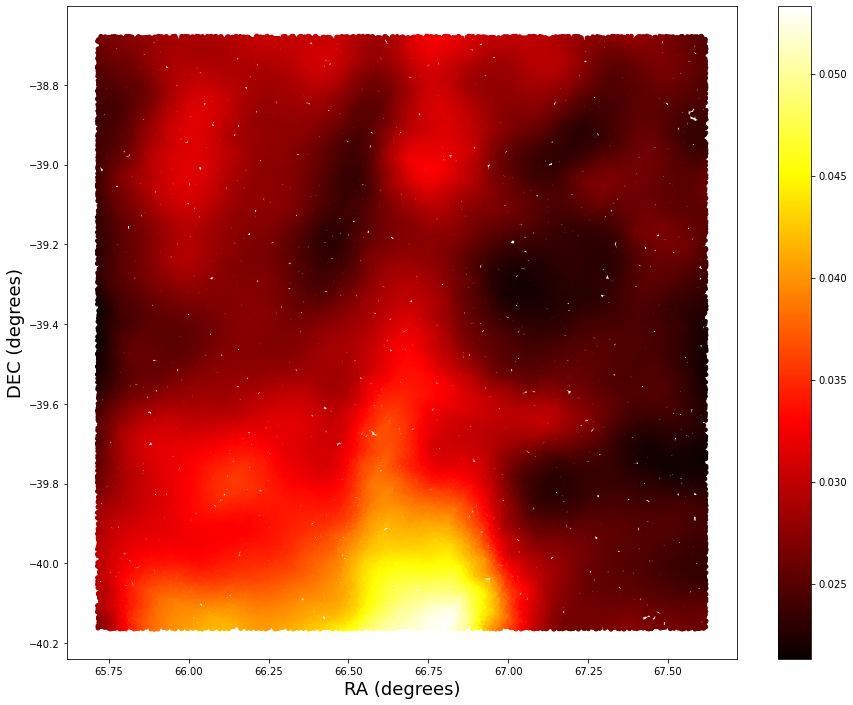

In [11]:
fig = plt.figure(figsize=(15,12))
plt.scatter(df['ra'][::10],df['dec'][::10],s=15,c=df['ebv'][::10],cmap='hot')
plt.xlabel("RA (degrees)",fontsize=18)
plt.ylabel("DEC (degrees)",fontsize=18)
plt.colorbar();

We see varying amounts of foreground dust with an E(B-V) going as high as 0.05.  For the u-band this means a de-reddening as high as 0.25 magnitudes, with lesser effects for longer wavelength bands.  Let's Select some non-blended, non-extended samples from the region with high E(B-V), and compare them to the input "truth" colors for stars with and without Milky Way dust included.

In [12]:
mask = (df['ebv']>.04) & (df['blendedness']<.05) & (df['extendedness']<.1) & (df['mag_i_cModel_dered']<23.5)
gooddf = df[mask]

For our comparison set, let's query the `dc2_truth_run2.2i_star_truth_summary` table, which contains AB fluxes for the stars both with and without the effects of dust included.  We'll select stars from the same region of the sky and compute the colors as -2.5*log10(ratio of fluxes) and save these in a separate dataframe named stardf:

In [13]:
starcat = GCRCatalogs.load_catalog("dc2_truth_run2.2i_star_truth_summary")
stardata = starcat.get_quantities(['ra','dec','flux_g','flux_r','flux_i','flux_z','flux_g_noMW','flux_r_noMW','flux_i_noMW','flux_z_noMW'],
                                  filters=['ra >66.5','ra<66.9','dec>-40.2','dec<-39.6'])

In [14]:
stardf = pd.DataFrame(stardata)
bands = ['g','r','i','z']
for i in range(3):
    stardf[f'{bands[i]}m{bands[i+1]}'] = -2.5*np.log10(stardf[f'flux_{bands[i]}']/stardf[f'flux_{bands[i+1]}'])
    stardf[f'{bands[i]}m{bands[i+1]}_nomw'] = -2.5*np.log10(stardf[f'flux_{bands[i]}_noMW']/stardf[f'flux_{bands[i+1]}_noMW'])

In [15]:
stardf.head()

,flux_g,flux_r,dec,flux_i,flux_z_noMW,flux_z,flux_g_noMW,flux_r_noMW,flux_i_noMW,ra,gmr,gmr_nomw,rmi,rmi_nomw,imz,imz_nomw
0,3.170678e+02,5.269622e+02,-39.605460,6.407886e+02,7.278507e+02,6.915118e+02,3.562754e+02,5.749263e+02,6.849571e+02,66.590173,0.551568,0.519566,0.212338,0.190128,0.082712,0.065947
1,1.906486e+06,2.591637e+06,-39.601620,2.923754e+06,3.210405e+06,3.046813e+06,2.150562e+06,2.833241e+06,3.129907e+06,66.602985,0.333351,0.299329,0.130917,0.108120,0.044763,0.027571
2,7.392736e+04,1.250206e+05,-39.601443,1.525894e+05,1.723681e+05,1.647238e+05,8.196076e+04,1.350477e+05,1.618698e+05,66.506655,0.570441,0.542203,0.216357,0.196696,0.083080,0.068228
3,1.071052e+05,3.335675e+05,-39.607471,5.639805e+05,7.597574e+05,7.261957e+05,1.183806e+05,3.599845e+05,5.980046e+05,66.501643,1.233433,1.207508,0.570201,0.551052,0.274474,0.259926
4,9.256304e+03,1.243859e+04,-39.602887,1.366302e+04,1.457573e+04,1.391146e+04,1.030542e+04,1.346823e+04,1.451931e+04,66.540339,0.320834,0.290612,0.101938,0.081589,0.019565,0.004210


Let's plot a color-color diagram of r-i vs g-r and show the observed star colors before and after dereddening, and compare to the truth table star colors with and without MW dust included:

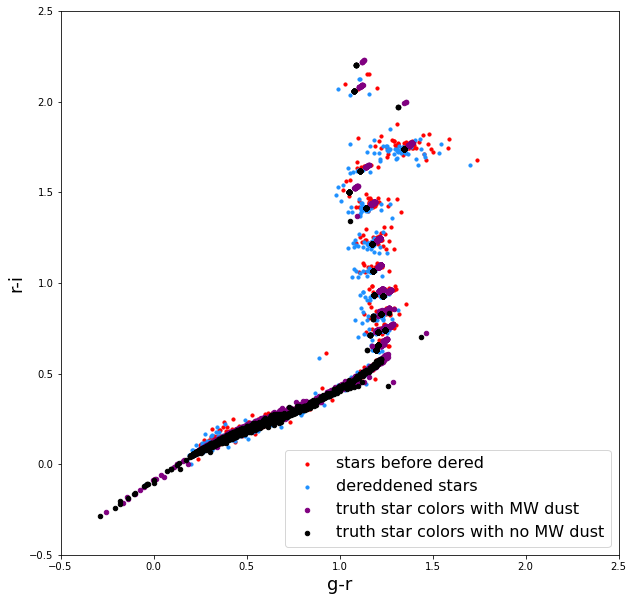

In [16]:
fig = plt.figure(figsize=(10,10))
plt.scatter(gooddf['mag_g']-gooddf['mag_r'],gooddf['mag_r']-gooddf['mag_i'],s=10,c='r',label="stars before dered")
plt.xlim(-.5,2.5)
plt.ylim(-.5,2.5)
plt.scatter(gooddf['mag_g_dered']-gooddf['mag_r_dered'],gooddf['mag_r_dered']-gooddf['mag_i_dered'],s=10,c='dodgerblue',label='dereddened stars')
plt.scatter(stardf['gmr'],stardf['rmi'],s=20,c='purple',label ="truth star colors with MW dust")
plt.scatter(stardf['gmr_nomw'],stardf['rmi_nomw'],s=20,c='k',label ="truth star colors with no MW dust" )
plt.xlim(-.5,2.5)
plt.ylim(-.5,2.5)
plt.xlabel("g-r",fontsize=18)
plt.ylabel("r-i",fontsize=18)
plt.legend(loc='lower right',fontsize=16);

We see the reddening vector as a shift in the colors, easily visible between the red and blue and black and purple points.  This reddening vector is somewhat aligned with the bluer stars in the stellar locus, but an offset is evident in the red M and L dwarfs.  We see that the dereddening procedure does, indeed, correct for the dust extinction. We can plot the two datasets on separate axes so things are a little more clear:

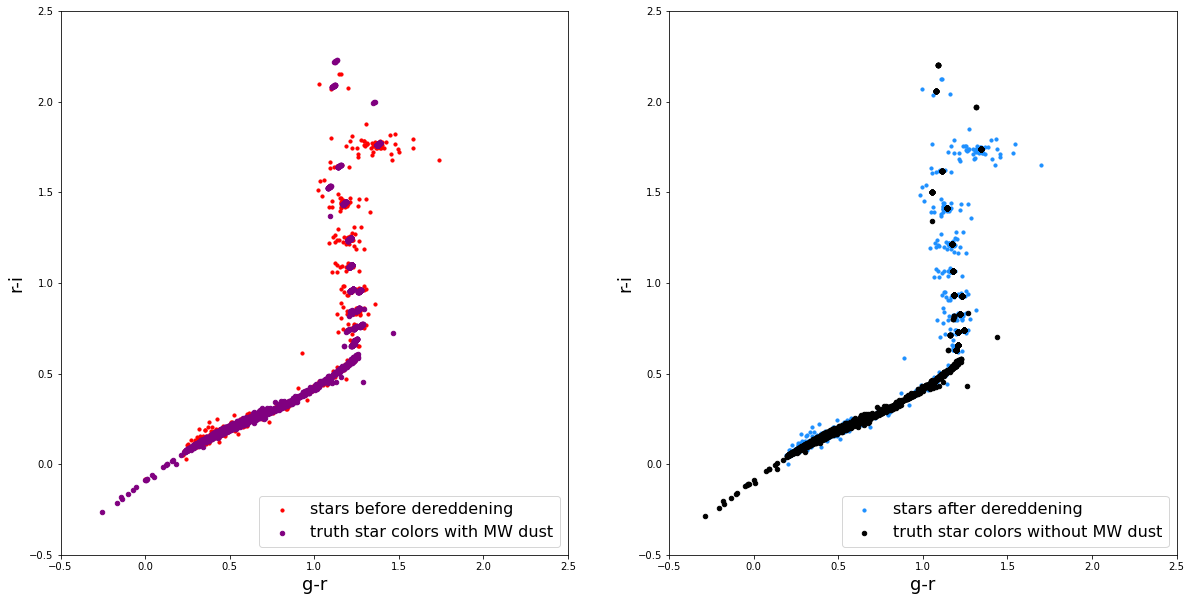

In [17]:
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.scatter(gooddf['mag_g']-gooddf['mag_r'],gooddf['mag_r']-gooddf['mag_i'],s=10,c='r',label="stars before dereddening")
plt.scatter(stardf['gmr'],stardf['rmi'],s=20,c='purple',label="truth star colors with MW dust")
#plt.scatter(stardf['gmr_nomw'],stardf['rmi_nomw'],s=50,c='k')
plt.xlim(-.5,2.5)
plt.ylim(-.5,2.5)
plt.xlabel("g-r",fontsize=18)
plt.ylabel("r-i",fontsize=18)
plt.legend(loc='lower right',fontsize=16)
plt.subplot(122)
plt.scatter(gooddf['mag_g_dered']-gooddf['mag_r_dered'],gooddf['mag_r_dered']-gooddf['mag_i_dered'],s=10,c='dodgerblue',label='stars after dereddening')
#plt.scatter(stardf['gmr'],stardf['rmi'],s=20,c='purple',label = "truth star colors")
plt.scatter(stardf['gmr_nomw'],stardf['rmi_nomw'],s=20,c='k',label='truth star colors without MW dust')
plt.xlim(-.5,2.5)
plt.ylim(-.5,2.5)
plt.xlabel("g-r",fontsize=18)
plt.ylabel("r-i",fontsize=18)
plt.legend(loc='lower right',fontsize=16);

And, finally, we will also plot i-z vs g-r:

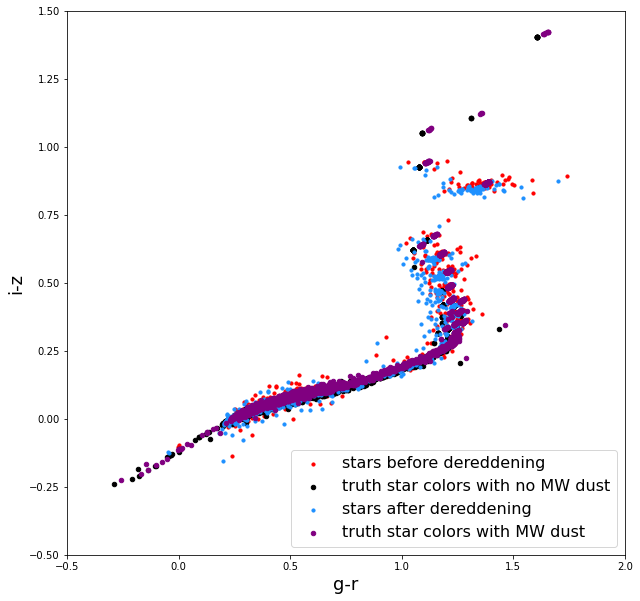

In [18]:
fig = plt.figure(figsize=(10,10))
plt.scatter(gooddf['mag_g']-gooddf['mag_r'],gooddf['mag_i']-gooddf['mag_z'],s=10,c='r',label="stars before dereddening")
plt.scatter(stardf['gmr_nomw'],stardf['imz_nomw'],s=20,c='k',label="truth star colors with no MW dust")
plt.scatter(gooddf['mag_g_dered']-gooddf['mag_r_dered'],gooddf['mag_i_dered']-gooddf['mag_z_dered'],s=10,c='dodgerblue',label='stars after dereddening')
plt.scatter(stardf['gmr'],stardf['imz'],s=20,c='purple',label='truth star colors with MW dust')
plt.xlim(-.5,2.)
plt.ylim(-.5,1.5)
plt.xlabel("g-r",fontsize=18)
plt.ylabel("i-z",fontsize=18)
plt.legend(loc='lower right',fontsize=16);

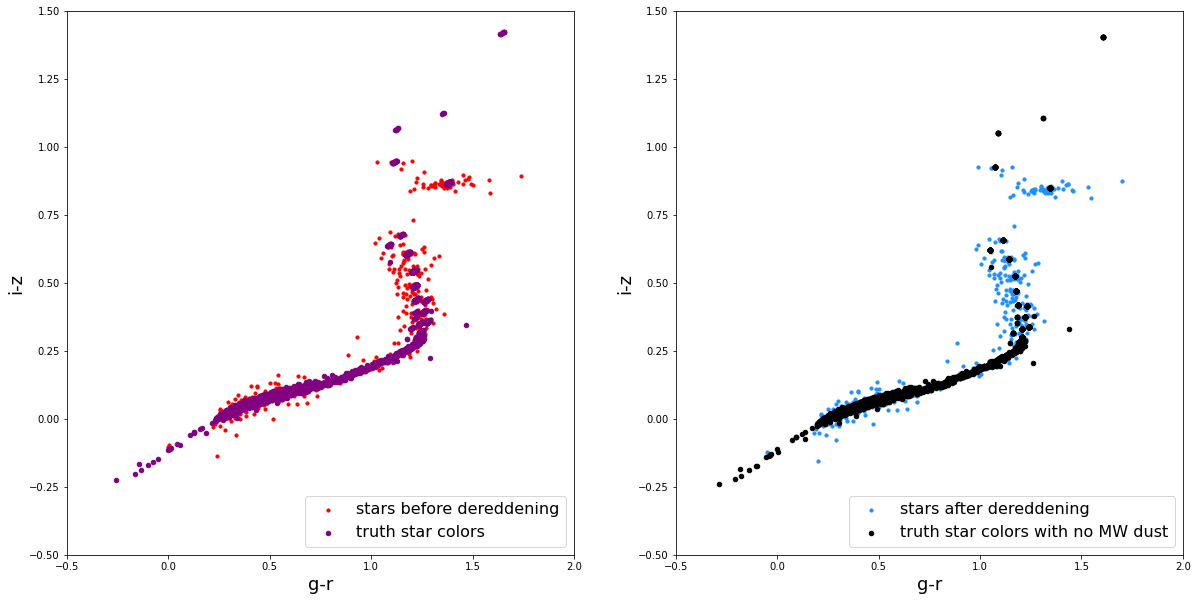

In [19]:
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.scatter(gooddf['mag_g']-gooddf['mag_r'],gooddf['mag_i']-gooddf['mag_z'],s=10,c='r',label="stars before dereddening")
plt.scatter(stardf['gmr'],stardf['imz'],s=20,c='purple',label='truth star colors')
#plt.scatter(stardf['gmr_nomw'],stardf['imz_nomw'],s=20,c='k',label ='truth star colors with no MW dust')
plt.xlim(-.5,2.)
plt.ylim(-.5,1.5)
plt.xlabel("g-r",fontsize=18)
plt.ylabel("i-z",fontsize=18)
plt.legend(loc='lower right',fontsize = 16)
plt.subplot(122)
plt.scatter(gooddf['mag_g_dered']-gooddf['mag_r_dered'],gooddf['mag_i_dered']-gooddf['mag_z_dered'],s=10,c='dodgerblue',label='stars after dereddening')
#plt.scatter(stardf['gmr'],stardf['imz'],s=20,c='purple',label='truth star colors')
plt.scatter(stardf['gmr_nomw'],stardf['imz_nomw'],s=20,c='k',label='truth star colors with no MW dust')
plt.xlim(-.5,2.)
plt.ylim(-.5,1.5)
plt.xlabel("g-r",fontsize=18)
plt.ylabel("i-z",fontsize=18)
plt.legend(loc='lower right',fontsize=16);

So, our dereddening worked correctly, and we see that the locus has shifted to match the truth star colors.